In [1]:
# Draw the simulation environmnt
# Draw sequencing and reach-avoid task
# dynamic model 
# draw a success rate table

In [2]:
import numpy as np
import torch
import torch.nn as nn
from datetime import datetime
import gym
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataset import Dataset
import sys
from collect_skill_trajectories import get_all_goal_value, from_real_dict_to_vector, ZONE_OBS_DIM
from stable_baselines3 import PPO
from train_dynamics import VFDynamics, VFDynamicsMLPLegacy, VFDynamicsMLPWithDropout
import rtamt
import time
#from gym.wrappers import RecordVideo
from gym.wrappers.monitor import video_recorder as VR
from random_shooting import RandomShootingController, MPController
from controller_evaluator import ControllerEvaluator
import math
from tqdm import tqdm
sys.path.append("/app/vfstl/src/GCRL-LTL/zones")
from envs import ZoneRandomGoalEnv
from envs.utils import get_zone_vector
from rl.traj_buffer import TrajectoryBufferDataset
import matplotlib.pyplot as plt
from PIL import Image
from controller_evaluator import ControllerEvaluator, plot_traj_2d, TaskSampler

/opt/conda/envs/myenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")

def cost_fn(state):
    return torch.randn(state.size()[0])


timeout = 1000
seed = 134
seed = 135
seed = 136
env = ZoneRandomGoalEnv(
    env=gym.make('Zones-8-v1', map_seed=seed, timeout=timeout), 
    primitives_path='/app/vfstl/src/GCRL-LTL/zones/models/primitives', 
    goals_representation=get_zone_vector(),
    use_primitves=True,
    rewards=[0, 1],
    device=device,
)

CUDA is available. Training on GPU.


In [4]:
obs = env.reset()

In [5]:
rgb_array = env.render(mode='rgb_array', camera_id=3, width=2060, height=2060)

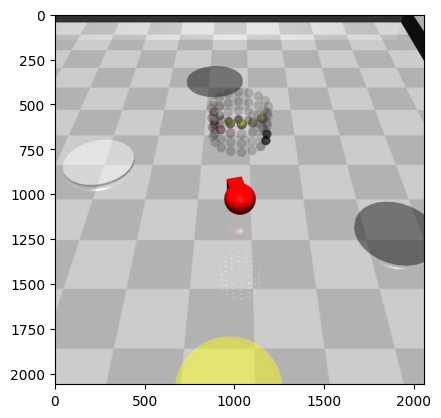

In [6]:
plt.imshow(rgb_array)

In [7]:
im = Image.fromarray(rgb_array)
time = datetime.now().ctime()
im.save("/app/vfstl/src/VFSTL/data_for_paper/robot_centered_{}.jpeg".format(time))

In [9]:
vf_num = 4
T_horizon = 4
skill_timesteps = 100

model_path = '/app/vfstl/src/GCRL-LTL/zones/models/goal-conditioned/best_model_ppo_8'
policy_model = PPO.load(model_path, device=device)
model = VFDynamicsMLP(len(env.goals))
model.load_state_dict(torch.load("/app/vfstl/src/VFSTL/dynamic_models/test_model_20240307_085639_11"))
dynamics = VFDynamics(model.to(device), len(env.goals))

controller = RandomShootingController(skill_timesteps, policy_model, dynamics, env.goals, T_horizon, 32768, 50, device)
#controller = MPController(skill_timesteps, policy_model, dynamics, env.goals, T_horizon, 32768, 50, device)
evaluator = ControllerEvaluator(controller, env)
# s,c,r,t = evaluator.one_step_prediction(stl)
# tensor_s = torch.tensor(s, device=device)
# tensor_s = tensor_s[None, :, :]
# ro = get_env_ground_truth_robustness_value(stl_env, tensor_s, env.zones, env.zone_types)
# sequence 
# stl_spec_env = 'eventually[0,200](R0 >= 0.8 and eventually[0,200] (Y0 >= 0.8))'
# stl_spec =  'eventually[0,2](R0 >= 0.8 and eventually[0,2] ((Y0 >= 0.8) and eventually[0,2] (J0 >= 0.8)))'

# reach avoid
#stl_spec_env = 'eventually[0,200](R0 >= 0.8 and eventually[0,200] (Y0 >= 0.8))'
#stl_spec =  'not(R0 >= 0.8) until[0, 4] (Y0 >= 0.8 and (not (W0 >= 0.8) until[0, 4] (J0 >= 0.8)))'

stl_spec =  'not(Y0 >= 0.8) until[0, 2] (R0 >= 0.8 and (not (J0 >= 0.8) until[0, 2] (W0 >= 0.8)))'
distances ,contorls, reward, timesteps, traj, zones_pos, goals, robot_in_zones = evaluator.one_epoch_prediction(stl_spec)

NameError: name 'VFDynamicsMLP' is not defined

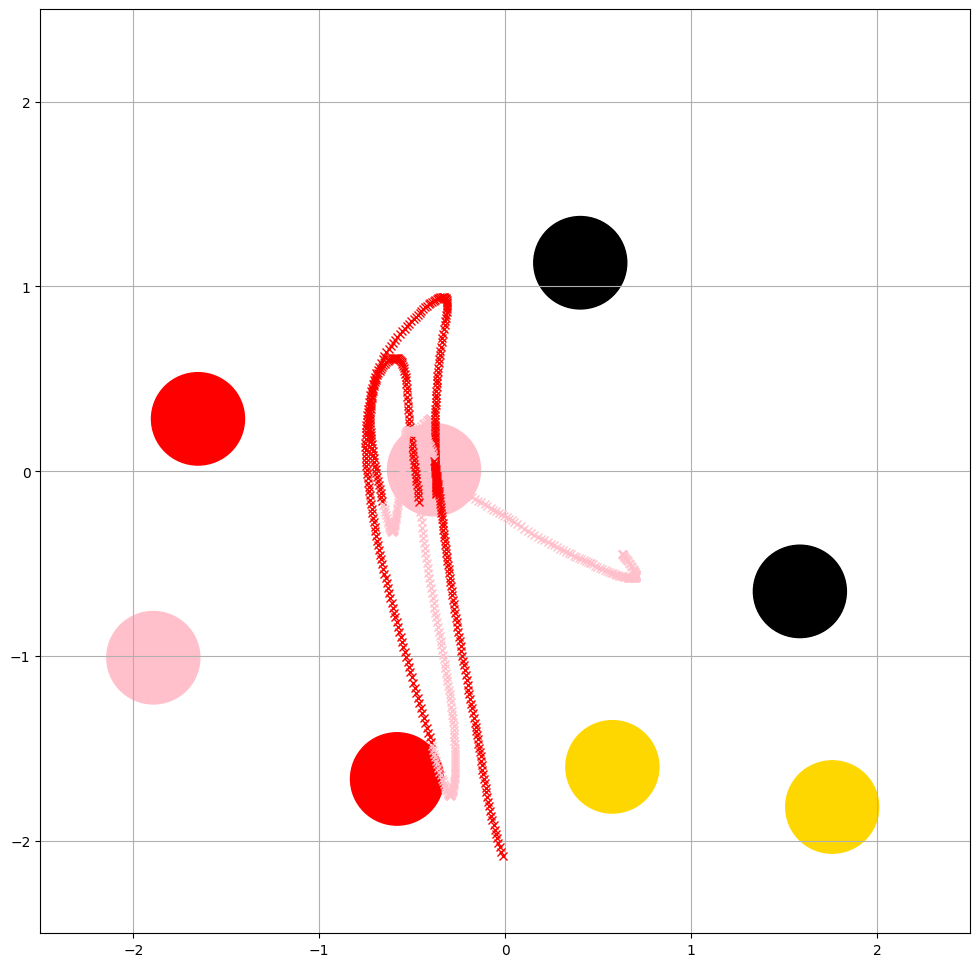

In [ ]:
a = datetime.now()
plot_traj_2d(env, np.array(traj), np.array(goals), '{}_traj_{}_{}'.format(a.ctime(), stl_spec, seed))

In [ ]:
a = datetime.now()

In [ ]:
a.ctime()

'Mon Mar 18 19:01:19 2024'

In [7]:
# plot reach_avoid 20 steps
with torch.no_grad():
    
    timeout = 1000
    seed = 134
    seed = 135
    seed = 136
    env = ZoneRandomGoalEnv(
        env=gym.make('Zones-8-v1', map_seed=seed, timeout=timeout), 
        primitives_path='/app/vfstl/src/GCRL-LTL/zones/models/primitives', 
        goals_representation=get_zone_vector(),
        use_primitves=True,
        rewards=[0, 1],
        device=device,
    )
    vf_num = 4
    T_horizon = 30
    skill_timesteps = 20

    model_path = '/app/vfstl/src/GCRL-LTL/zones/models/goal-conditioned/best_model_ppo_8'
    policy_model = PPO.load(model_path, device=device)
    model = VFDynamicsMLPWithDropout(len(env.goals)).to(device)
    model.load_state_dict(torch.load("/app/vfstl/src/VFSTL/dynamic_models/new_20_timsteps_direct_model_20240320_075521_49", map_location=device)) 
    dynamics = VFDynamics(model.to(device), len(env.goals))
    stl_spec =  'not(W0 >= 0.8) until[0, 15] (J0 >= 0.8 and (not (W0 >= 0.8) until[0, 15] (R0 >= 0.8)))'
    stl_spec = 'eventually[0, 20] always[0,10] (W0 >= 0.8)'
    #controller = RandomShootingController(skill_timesteps, policy_model, dynamics, env.goals, T_horizon, 500_000,1, device)
    controller = MPController(skill_timesteps, policy_model, dynamics, env.goals, T_horizon, 500_000, 1, device)
    #controller = MPController(skill_timesteps, policy_model, dynamics, env.goals, T_horizon, 32768, 50, device)
    evaluator = ControllerEvaluator(controller, env)
    # s,c,r,t = evaluator.one_step_prediction(stl)
    # tensor_s = torch.tensor(s, device=device)
    # tensor_s = tensor_s[None, :, :]
    # ro = get_env_ground_truth_robustness_value(stl_env, tensor_s, env.zones, env.zone_types)
    # sequence 
    # stl_spec_env = 'eventually[0,200](R0 >= 0.8 and eventually[0,200] (Y0 >= 0.8))'
    # stl_spec =  'eventually[0,2](R0 >= 0.8 and eventually[0,2] ((Y0 >= 0.8) and eventually[0,2] (J0 >= 0.8)))'

    # reach avoid
    #stl_spec_env = 'eventually[0,200](R0 >= 0.8 and eventually[0,200] (Y0 >= 0.8))'
    #stl_spec =  'not(R0 >= 0.8) until[0, 4] (Y0 >= 0.8 and (not (W0 >= 0.8) until[0, 4] (J0 >= 0.8)))
    distances ,contorls, reward, timesteps, traj, zones_pos, goals, robot_in_zones = evaluator.one_epoch_prediction(stl_spec)

generating time: 0.000225067138671875
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
generating time: 0.0001499652862548828
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
generating time: 9.799003601074219e-05
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
generating time: 8.58306884765625e-05
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
generating time: 8.630752563476562e-05
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
generating time: 8.440017700195312e-05
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
generating time: 8.130073547363281e-05
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
generating time: 7.033348083496094e-05
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
generating time: 9.918212890625e-05
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
generating time: 7.081031799316406e-05
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
generating time: 8.392333984375e-05
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
generating time: 7.200241088867188e-05
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
generating time: 

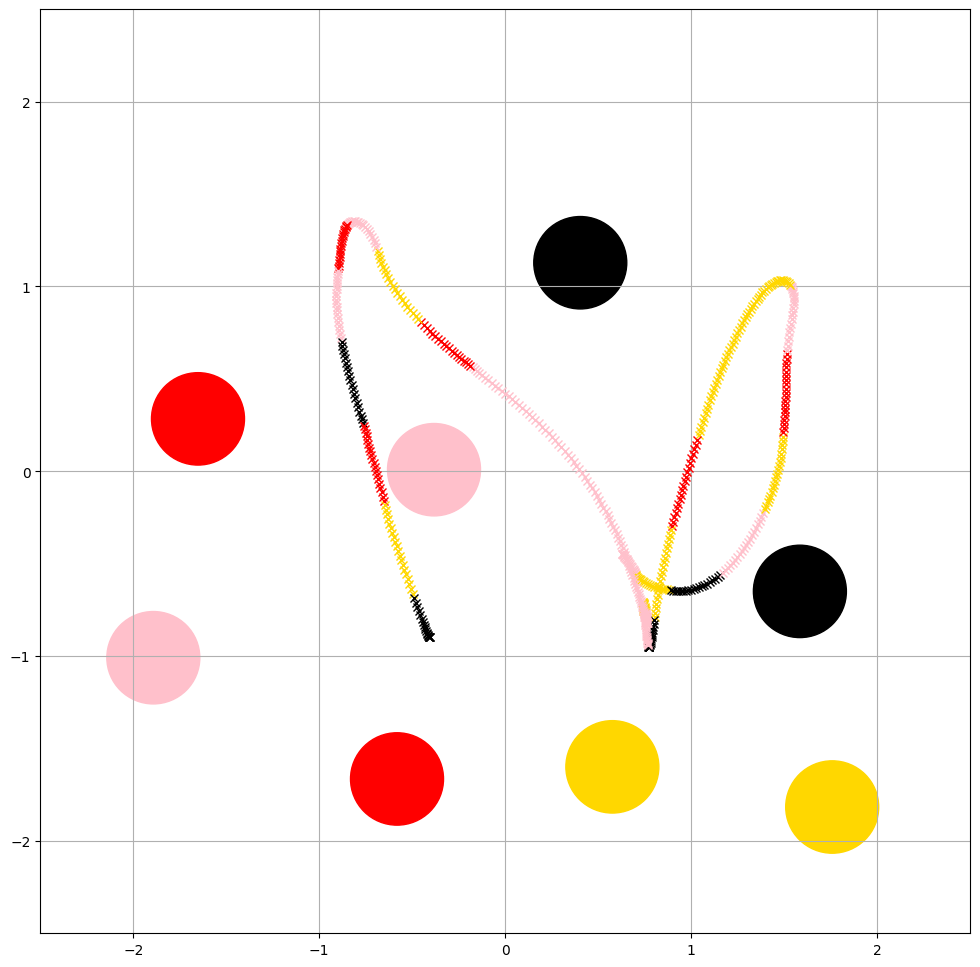

In [8]:
a = datetime.now()

plot_traj_2d(env, np.array(traj), np.array(goals), '{}_traj_{}_{}'.format(a.ctime(), stl_spec, seed))

In [5]:
from IPython.display import SVG

In [7]:
svgddata = '''

<svg width="200" height="250" xmlns="http://www.w3.org/2000/svg">
  <!-- Draw the tree structure -->
  <!-- Root node -->
  <circle cx="100" cy="30" r="20" stroke="black" stroke-width="2" fill="white" />
  <text x="95" y="35" font-family="Arial" font-size="12">Root</text>
  
  <!-- Selection path -->
  <line x1="100" y1="50" x2="60" y2="90" stroke="black" stroke-width="2"/>
  <circle cx="60" cy="100" r="20" stroke="black" stroke-width="2" fill="white"/>
  <text x="55" y="105" font-family="Arial" font-size="12">S</text>
  
  <!-- Expansion -->
  <line x1="60" y1="120" x2="60" y2="160" stroke="black" stroke-width="2"/>
  <circle cx="60" cy="170" r="20" stroke="black" stroke-width="2" fill="white"/>
  <text x="55" y="175" font-family="Arial" font-size="12">E</text>
  
  <!-- Simulation -->
  <line x1="60" y1="190" x2="60" y2="230" stroke="black" stroke-width="2" stroke-dasharray="5,5"/>
  <text x="55" y="245" font-family="Arial" font-size="12">Sim</text>
  
  <!-- Backpropagation path -->
  <line x1="70" y1="110" x2="100" y2="70" stroke="blue" stroke-width="2" stroke-dasharray="5,5"/>
  <line x1="100" y1="50" x2="130" y2="90" stroke="blue" stroke-width="2" stroke-dasharray="5,5"/>
  <circle cx="140" cy="100" r="20" stroke="blue" stroke-width="2" fill="white"/>
  <text x="135" y="105" font-family="Arial" font-size="12" fill="blue">B</text>
  
  <!-- Additional nodes to imply more tree depth -->
  <circle cx="140" cy="170" r="20" stroke="black" stroke-width="2" fill="white"/>
  <line x1="140" y1="120" x2="140" y2="160" stroke="black" stroke-width="2"/>
  <text x="135" y="175" font-family="Arial" font-size="12">...</text>
</svg>

'''

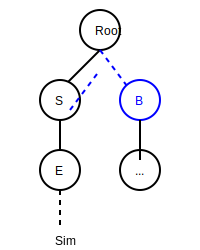

In [8]:
SVG(svgddata)